In [1]:
from analysis_helpers import *

c:\Users\david\anaconda3\envs\basic\lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


In [2]:
directory = '../../interviews_corrected/5_conditions/**/' 

df = load_and_combine_csv(directory)

print(df["Condition"].unique())
# Drop the rows equal to 0 for the column condition
df = df[df["Condition"] != 0]
print(df["Condition"].unique())

Found 82 CSV files.
[1 'C' 'I' 0]
[1 'C' 'I']


In [3]:
# If only want to focus on participant speaker
df_participant = df[df["Speaker"] == "Participant"]
df_interviewer = df[df["Speaker"] == "Interviewer"]

# Functions

In [8]:
def cluster_tfidf_kmeans(df, n_clusters=2):
    #vectorizer = TfidfVectorizer(max_features=1000)
    vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1, 3))
    pca = PCA(n_components=2)
    
    clustered_dfs = []
    tfidf_matrices = []  # Store X_tfidf matrices for each experiment
    
    for experiment in df['Experiment'].unique():
        experiment_df = df[df['Experiment'] == experiment].copy()
        
        # TF-IDF transformation
        X_tfidf = vectorizer.fit_transform(experiment_df['preprocessed_content']).toarray()
        tfidf_matrices.append(X_tfidf)
        
        # PCA for dimensionality reduction
        X_pca = pca.fit_transform(X_tfidf)
        
        # KMeans clustering
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        experiment_df.loc[:, 'cluster'] = kmeans.fit_predict(X_tfidf)
        
        # Append the clustered DataFrame and PCA data for visualization
        clustered_dfs.append((experiment_df, X_pca))
    
    return clustered_dfs, tfidf_matrices  # Return both clustered DataFrames and TF-IDF matrices

def cluster_bert_kmeans(df, model, n_clusters=2):
    pca = PCA(n_components=2)
    clustered_dfs = []
    embedding_matrices = []  # Store embeddings for each experiment
    
    for experiment in df['Experiment'].unique():
        experiment_df = df[df['Experiment'] == experiment].copy()
        
        # Compute BERT embeddings
        X_embeddings = model.encode(experiment_df['preprocessed_content'].tolist())
        embedding_matrices.append(X_embeddings)
        
        # Dimensionality reduction with PCA for visualization
        X_pca = pca.fit_transform(X_embeddings)
        
        # KMeans clustering
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        experiment_df['cluster'] = kmeans.fit_predict(X_embeddings)
        
        clustered_dfs.append((experiment_df, X_pca))
    
    return clustered_dfs, embedding_matrices

from sklearn.metrics import silhouette_score

def find_optimal_clusters(data, max_k):
    iters = range(2, max_k+1)
    sse = []
    silhouette_scores = []
    for k in iters:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data)
        sse.append(kmeans.inertia_)
        silhouette_avg = silhouette_score(data, kmeans.labels_)
        silhouette_scores.append(silhouette_avg)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(iters, sse, marker='o')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Sum of Squared Errors (SSE)')
    plt.title('Elbow Method')
    plt.subplot(1, 2, 2)
    plt.plot(iters, silhouette_scores, marker='o')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Analysis')
    plt.show()

from sklearn.cluster import DBSCAN

def cluster_bert_dbscan(df, model, eps=0.5, min_samples=5):
    clustered_dfs = []
    embedding_matrices = []
    
    for experiment in df['Experiment'].unique():
        experiment_df = df[df['Experiment'] == experiment].copy()
        
        # Compute BERT embeddings
        X_embeddings = model.encode(experiment_df['preprocessed_content'].tolist())
        embedding_matrices.append(X_embeddings)
        
        # DBSCAN clustering
        dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='cosine')
        labels = dbscan.fit_predict(X_embeddings)
        experiment_df['cluster'] = labels
        
        clustered_dfs.append((experiment_df, None))  # No PCA needed here
    return clustered_dfs, embedding_matrices

from sklearn.manifold import TSNE

def visualize_clusters_tsne(clustered_dfs, embedding_matrices):
    for (experiment_df, _), embeddings in zip(clustered_dfs, embedding_matrices):
        experiment = experiment_df['Experiment'].iloc[0]
        labels = experiment_df['cluster']
        
        tsne = TSNE(n_components=2, perplexity=5, random_state=42)
        X_tsne = tsne.fit_transform(embeddings)
        
        plt.figure(figsize=(10, 7))
        plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='viridis', alpha=0.7)
        plt.title(f't-SNE Clustering Visualization for Experiment {experiment}')
        plt.xlabel('t-SNE Component 1')
        plt.ylabel('t-SNE Component 2')
        plt.colorbar(label='Cluster')
        plt.show()

from wordcloud import WordCloud

def create_wordclouds(df):
    clusters = df['cluster'].unique()
    for cluster in clusters:
        cluster_text = ' '.join(df[df['cluster'] == cluster]['preprocessed_content'])
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(cluster_text)
        plt.figure(figsize=(15, 7.5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'Word Cloud for Cluster {cluster}')
        plt.show()


# Code for the analysis

In [4]:
# Preprocess text with the updated function
df_participant['preprocessed_content'] = df_participant['Content'].apply(preprocess_text)

# Group data by Experiment and Participant
grouped_df = df_participant.groupby(['Experiment', 'Id'])['preprocessed_content'].apply(' '.join).reset_index()

# Load the BERT model once
model = SentenceTransformer('all-MiniLM-L6-v2')

C:\Users\david\AppData\Local\Temp\ipykernel_3516\908853607.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_participant['preprocessed_content'] = df_participant['Content'].apply(preprocess_text)


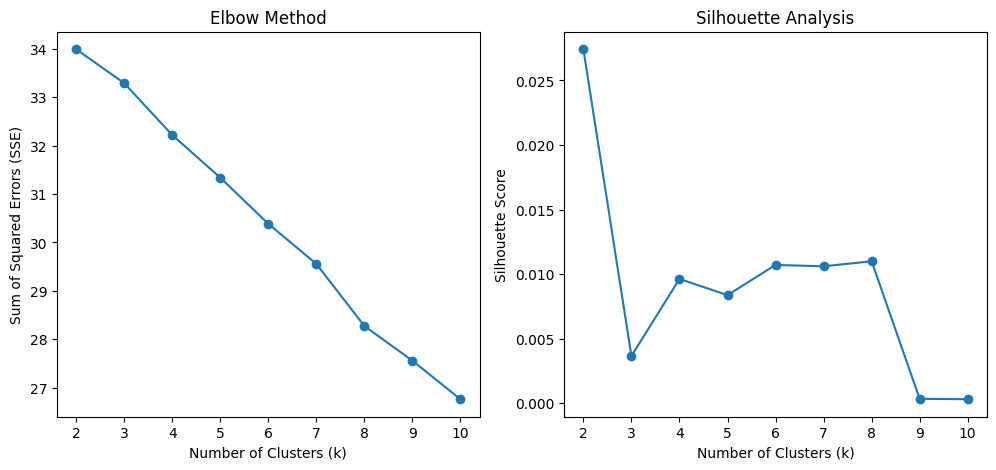

In [6]:
# Determine optimal number of clusters for TF-IDF
X_tfidf = TfidfVectorizer(max_features=1000, ngram_range=(1, 3)).fit_transform(grouped_df['preprocessed_content']).toarray()
find_optimal_clusters(X_tfidf, max_k=10)

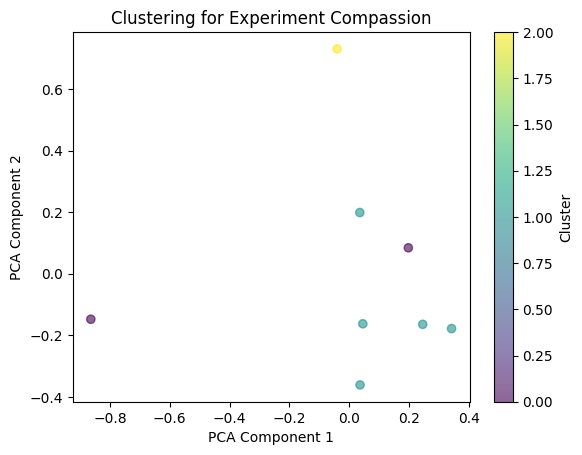

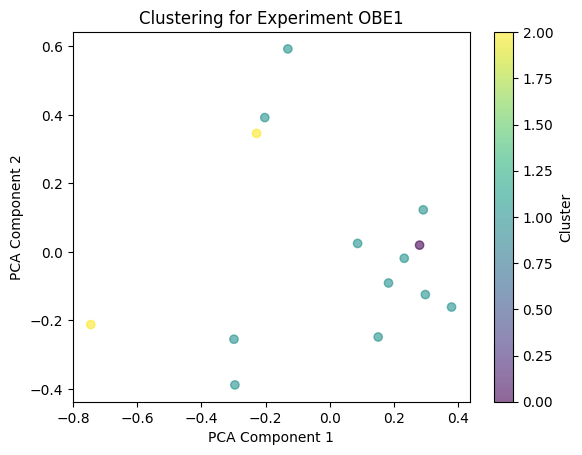

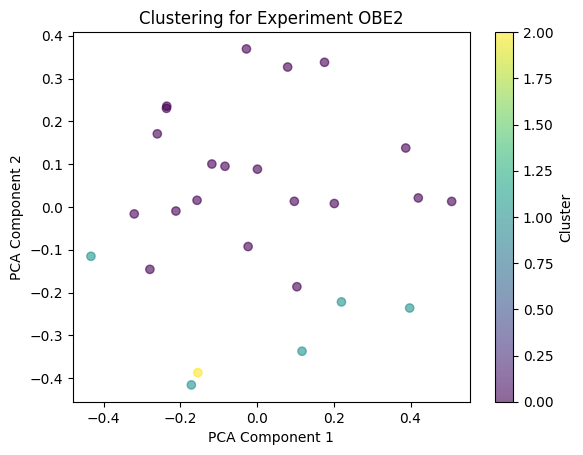

In [11]:
# Based on the plots, set optimal_k
optimal_k = 3

# Perform TF-IDF clustering
clustered_dfs_tfidf, tfidf_matrices = cluster_tfidf_kmeans(grouped_df, n_clusters=optimal_k)

# Visualize clusters with PCA
visualize_clusters(clustered_dfs_tfidf)

# Create word clouds for TF-IDF clusters
#for experiment_df, _ in clustered_dfs_tfidf:
    #create_wordclouds(experiment_df)

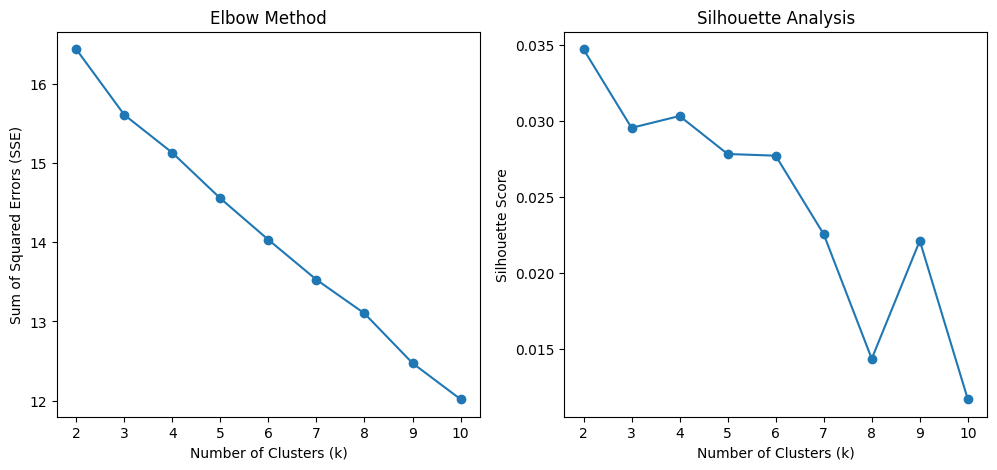

In [12]:
# Repeat for BERT embeddings
X_embeddings = model.encode(grouped_df['preprocessed_content'].tolist())
find_optimal_clusters(X_embeddings, max_k=10)

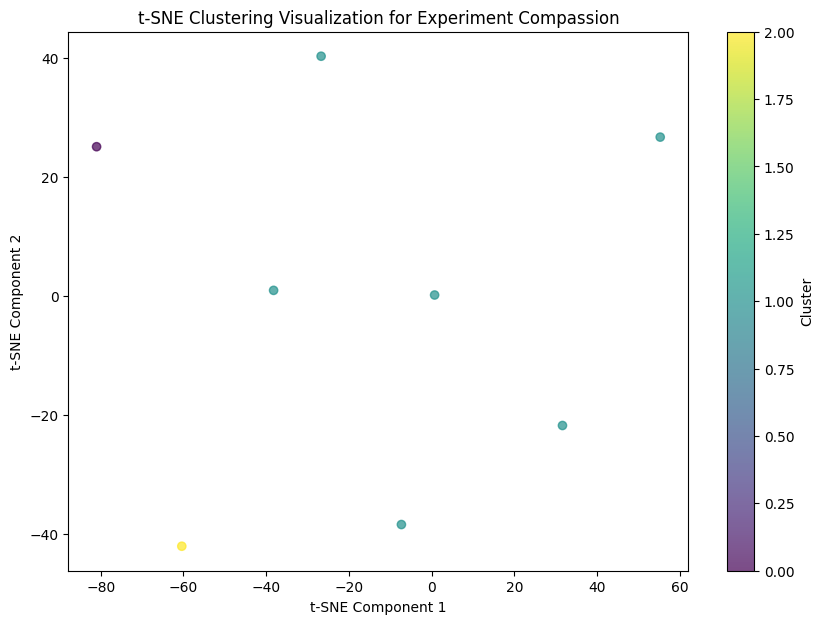

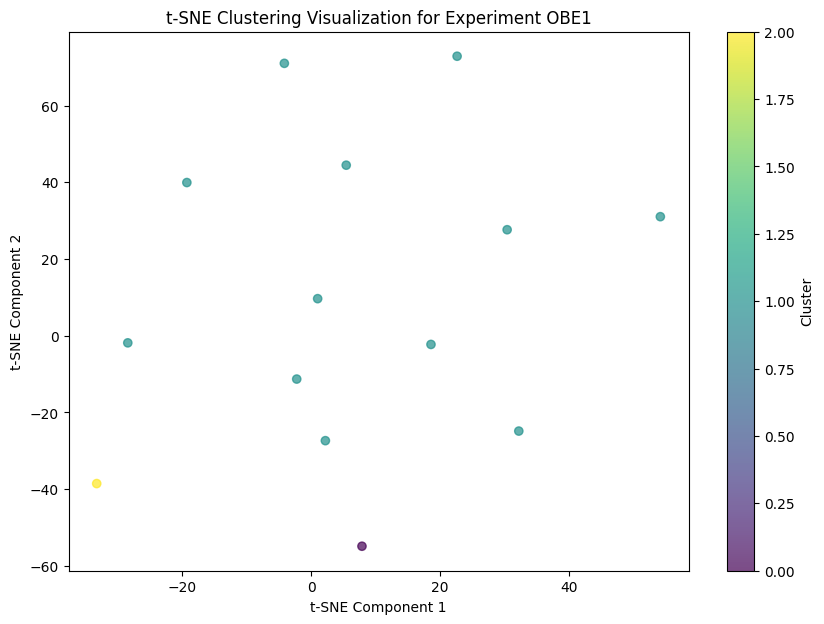

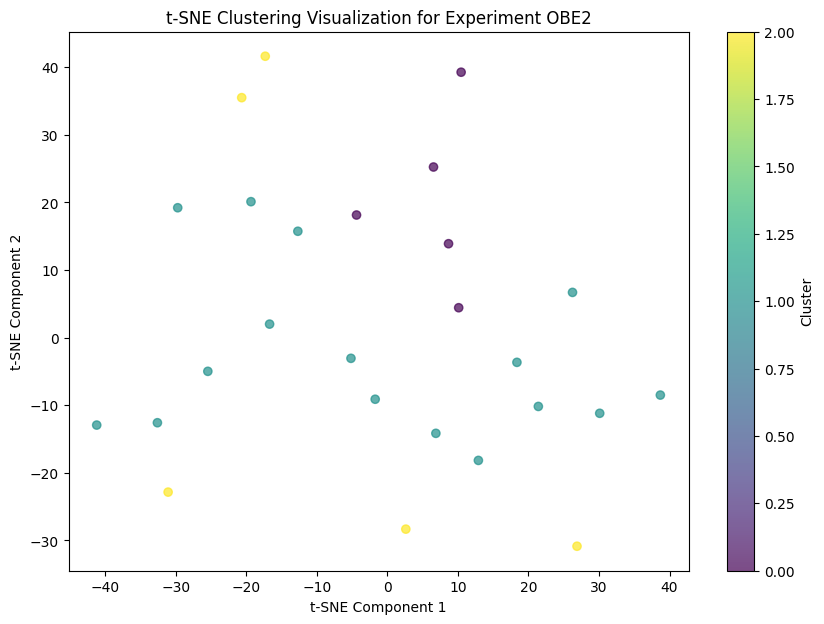

In [13]:
# Based on the plots, set optimal_k
optimal_k_bert = 3

clustered_dfs_bert, bert_matrices = cluster_bert_kmeans(grouped_df, model, n_clusters=optimal_k_bert)

# Visualize BERT clusters with t-SNE
visualize_clusters_tsne(clustered_dfs_bert, bert_matrices)

# Create word clouds for BERT clusters
#for experiment_df, _ in clustered_dfs_bert:
    #create_wordclouds(experiment_df)